In [3]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
import statsmodels.api as sm

In [6]:
# read data
equity = pd.read_excel('../data/data2.xlsx',index_col=0, sheet_name='equity')
factor = pd.read_excel('../data/data2.xlsx',index_col=0, sheet_name='factor')

# simple return
factor_return = factor.pct_change().dropna()
equity_return = equity.pct_change().dropna()

In [7]:
# reqExp = required explanation power = determine the number of PC used
reqExp = 0.8

# reqCor = required minimum correlation for the factor with the eigen portfolio
reqCorr = 0.4

# reqFcorr = maximum between-factor correlation, to avoid multicollinearity
reqFcorr = 0.7

In [13]:
# calculate covariance matrix
eqt_ret_cov = equity_return.cov().to_numpy()

# calculate eigen values and eigen vectors
w, v = np.linalg.eig(eqt_ret_cov)

# find required number of PC needed to reach reqExp
tmp = w / w.sum()
reqPC = np.where(tmp.cumsum()>reqExp)[0][0]+1

# df for factor loadings
pca_loadings_df = pd.DataFrame(v[:, :reqPC], index=equity_return.columns, columns=['PC{}'.format(i+1) for i in range(reqPC)])
pca_loadings_df

# The first PC seems to be a general level of global returns, all have the same signs with mean of 21%
# The second PC seems to reflect a contrast of developed markets vs emerging markets
# The third PC seems to reflect the locational difference between fast-growing Asian economies vs the western world
# We seem not able to assign themes to the remaining PCs

pca_loadings_df

,PC1,PC2,PC3
NKY Index,0.047939,0.205353,0.435300
HSI Index,0.063540,-0.172475,-0.666759
AS51 Index,0.036952,0.112135,0.140768
HSCEI Index,0.083284,-0.527588,-0.790839
SHSZ300 Index,0.063919,-1.135297,1.409068
TWSE Index,0.048226,0.004959,-0.546467
KOSPI Index,0.045351,0.001654,-0.307775
NIFTY Index,0.059900,0.082754,-0.926757
FSSTI Index,0.053009,-0.004330,-0.367874
SPX Index,0.040514,0.180000,0.162421


,PC1,PC2,PC3
2006-01-30,1.000000,1.000000,1.000000
2006-02-28,1.290514,1.282034,0.492199
2006-03-28,1.769577,0.721106,0.326128
2006-04-28,2.295575,2.016867,1.066400
2006-05-28,1.346264,5.151572,-3.193594
...,...,...,...
2016-09-30,12.123964,19.823293,-4.099269
2016-10-31,12.414412,20.600122,-4.319664
2016-11-30,12.606046,22.673840,-9.258427
2016-12-30,12.666642,18.493062,-9.928862


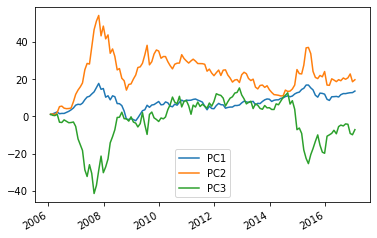

In [23]:
# eigen portfolios cumulative return since start
pca_cum_port_df = pd.DataFrame(np.dot((1+equity_return).cumprod()-1, (pca_loadings_df/pca_loadings_df.sum()).to_numpy()),index=equity_return.index, columns=['PC{}'.format(i+1) for i in range(reqPC)])

# change starting value to 1
pca_cum_port_df = pca_cum_port_df/pca_cum_port_df.iloc[0, :]

pca_cum_port_df.plot()

# Constant rebalance to maintain weight
pca_port_df = pd.DataFrame(np.dot(equity_return, (pca_loadings_df/pca_loadings_df.sum()).to_numpy()),index=equity_return.index, columns=['PC{}'.format(i+1) for i in range(reqPC)])
pca_cum_port_df

In [39]:
### This section is to find the most relevant factors (actual assets/indics) to represent the principal components (eigen portfolios)
# the idea is that we believe there are real fundamental factors that are driving each Principal components.
# For example, the first PC correspond to general global return, so it is driven by global economic growth
# Second PC may correspond to contrast of developed markets vs emerging markets, and emerging markets are more affected by flow (reflected by currency indics)
# So we want to reconcile the PC with those fundamental factors

factors_list = set()
flag=False
for pca_i in range(pca_port_df.shape[1]):
    pca_port_i = pca_port_df.iloc[:, pca_i]
    for factor_i in range(factor_return.shape[1]):
        r, p = pearsonr(factor_return.iloc[:, factor_i], pca_port_i)
        if abs(r) >= reqCorr:
            if not flag:
                factors_list = factors_list.union({factor_i})
                flag=True
            else:
                to_include = True
                for factor_j in factors_list:
                    if factor_i == factor_j:
                        continue
                    else:
                        r, p = pearsonr(factor_return.iloc[:, factor_i], factor_return.iloc[:, factor_j])
                        if abs(r) > reqFcorr:
                            to_include = False
                            break
                if to_include:
                    factors_list = factors_list.union({factor_i})

# Selected factors
factors_list = list(factor_return.columns[list(factors_list)])
selected_factors = factor_return[factors_list]
selected_factors.corr()

,AUDJPY CURNCY,EUR Curncy,INR CURNCY,GBP Curncy,CL1 COMDTY,HG1 COMDTY,XOVER CDSI GENERIC 5Y Corp,CITLY1U5 Index,CDBR1U5 Index,CJGB1U5 Index
AUDJPY CURNCY,1.000000,0.543086,-0.493160,0.518967,0.538083,0.525401,-0.463553,-0.502890,-0.441944,-0.360804
EUR Curncy,0.543086,1.000000,-0.500469,0.587618,0.475898,0.472806,-0.249635,-0.329391,-0.351831,-0.249951
INR CURNCY,-0.493160,-0.500469,1.000000,-0.379350,-0.242549,-0.331265,0.379140,0.329592,0.303732,0.286693
GBP Curncy,0.518967,0.587618,-0.379350,1.000000,0.553210,0.490287,-0.360181,-0.366126,-0.400997,-0.367654
CL1 COMDTY,0.538083,0.475898,-0.242549,0.553210,1.000000,0.536193,-0.252025,-0.261401,-0.178282,-0.263325
HG1 COMDTY,0.525401,0.472806,-0.331265,0.490287,0.536193,1.000000,-0.227584,-0.236168,-0.330244,-0.267981
XOVER CDSI GENERIC 5Y Corp,-0.463553,-0.249635,0.379140,-0.360181,-0.252025,-0.227584,1.000000,0.593700,0.366102,0.488723
CITLY1U5 Index,-0.502890,-0.329391,0.329592,-0.366126,-0.261401,-0.236168,0.593700,1.000000,0.578288,0.576734
CDBR1U5 Index,-0.441944,-0.351831,0.303732,-0.400997,-0.178282,-0.330244,0.366102,0.578288,1.000000,0.414617
CJGB1U5 Index,-0.360804,-0.249951,0.286693,-0.367654,-0.263325,-0.267981,0.488723,0.576734,0.414617,1.000000


In [40]:
## Now that we have found some good real-world representations of eigen portfolios, lets see how well they explain volatility of individual stocks
## we will use linear regression for this purpose

# standardize returns. This is to remove keep intercept term of regression close to 0
selected_factors = (selected_factors - selected_factors.mean()) / selected_factors.std()
eqty_ret_std = (equity_return - equity_return.mean()) / equity_return.std()

X = selected_factors.to_numpy()
X = sm.add_constant(X)
r_sqrt = list()
betas = list()
# Run regression on Equity returns using selected factors as predictors
for equity_i in range(eqty_ret_std.shape[1]):
    model = sm.OLS(endog=eqty_ret_std.iloc[:, equity_i], exog=X)
    result = model.fit()
    r_sqrt.append(result.rsquared)
    betas.append(result.params)

r_sqrt_df =  pd.DataFrame(r_sqrt, index=equity_return.columns, columns=['R squared'])
# R squared are pretty high for some indics. This means over half of the volatility can actually be represented the fundamental factors
# which are commodity / currency / pairs that represent flow
r_sqrt_df

,R squared
NKY Index,0.671270
HSI Index,0.642509
AS51 Index,0.600263
HSCEI Index,0.527309
SHSZ300 Index,0.234856
TWSE Index,0.530264
KOSPI Index,0.514848
NIFTY Index,0.543283
FSSTI Index,0.677165
SPX Index,0.687352


In [41]:
betas_df = pd.DataFrame(betas, index=equity_return.columns)
betas_df = betas_df.T
betas_df.index = ['cost'] + list(selected_factors.columns)

# We can also look at individual importance of each factor to each index.
# Intercepts are all 0, good
# Let's interpret SPX Index together
# The factor with highest betas is AUDJPY CURNCY, this pair represent bullishness.
# Because JPY is an indicator of flow to equity (when economy is good, ppl borrow JPY at zero rate, sell for USD and enter US stock market)
# AUD represent flow to commodity, so when AUD is strengthening, it means economy is doing well, demand is strong and commodity is doing well
# so AUD/JPY represent bulllishness of stock market. This is also the largest coefficient in the regression! So the method is accurate!
betas_df

,NKY Index,HSI Index,AS51 Index,HSCEI Index,SHSZ300 Index,TWSE Index,KOSPI Index,NIFTY Index,FSSTI Index,SPX Index,NDX Index,ibov Index,SX5E Index,UKX Index,CAC Index,DAX Index,SMI Index,IBEX Index,OMX Index,AEX Index
cost,1.387779e-17,0.000000,5.551115e-17,-9.714451e-17,-4.163336e-17,1.387779e-17,0.000000,-3.469447e-17,6.938894e-18,-4.163336e-17,-6.938894e-17,0.000000,0.000000,-1.387779e-17,-2.775558e-17,-2.775558e-17,0.000000,0.000000,1.387779e-17,5.551115e-17
AUDJPY CURNCY,6.983012e-01,0.287044,1.638116e-01,3.754218e-01,1.564348e-01,3.242495e-01,0.188723,2.102420e-01,2.154427e-01,1.989067e-01,2.097058e-01,0.192910,0.117679,1.375199e-01,1.118323e-01,1.621848e-01,0.151740,0.039042,3.229299e-01,1.398483e-01
EUR Curncy,-1.973910e-01,-0.002213,-7.590769e-03,1.560038e-02,-1.161149e-01,3.967162e-02,-0.047882,-2.944688e-02,-9.099429e-02,8.752931e-02,-4.444998e-03,0.085213,-0.044745,1.520817e-01,-5.366938e-02,-1.390092e-01,-0.235942,0.138879,-2.020443e-01,-2.663335e-01
INR CURNCY,-3.547550e-02,-0.270807,-1.500548e-01,-2.187371e-01,-1.127282e-01,-1.953196e-01,-0.196124,-4.556521e-01,-3.628211e-01,-1.465162e-01,-1.686720e-01,-0.223960,-0.174115,-1.978955e-01,-1.404354e-01,-2.226041e-01,-0.113408,-0.135319,-1.997604e-01,-2.308840e-01
GBP Curncy,3.574253e-02,0.091810,-1.290536e-01,-4.722893e-03,1.658940e-01,-9.534032e-02,-0.075064,-5.594763e-02,8.485512e-02,-9.328566e-02,-4.057520e-02,-0.084605,-0.062706,-4.433785e-01,-1.098084e-01,-7.183575e-02,-0.044738,0.072461,-7.343103e-02,-6.287989e-02
CL1 COMDTY,-4.687477e-02,0.110820,1.364325e-02,1.026794e-01,-1.308619e-01,6.066534e-02,0.117900,9.252656e-02,8.041092e-02,5.445378e-02,7.141915e-02,0.161214,0.003612,1.494208e-01,4.083151e-02,2.020710e-02,0.019847,-0.070296,-5.131338e-02,1.364787e-01
HG1 COMDTY,-9.731348e-02,0.047764,1.753263e-01,2.256138e-02,2.339854e-01,2.586199e-01,0.238112,-3.968296e-02,1.208145e-01,1.293814e-01,8.515851e-02,0.169954,0.022536,1.586453e-01,5.975737e-02,1.791624e-02,0.029472,-0.049933,1.116540e-01,1.105965e-01
XOVER CDSI GENERIC 5Y Corp,-1.702119e-01,-0.017357,-2.439996e-01,5.639724e-02,-2.349290e-02,-2.164263e-02,0.005388,1.459687e-02,-7.496554e-02,-2.867210e-01,-2.423639e-01,-0.093826,-0.405513,-3.453315e-01,-4.249125e-01,-4.354947e-01,-0.294534,-0.254789,-2.072523e-01,-2.576857e-01
CITLY1U5 Index,3.318036e-02,-0.086321,-1.675688e-01,-6.535109e-02,-1.652510e-01,-2.337012e-01,-0.205137,-1.883787e-01,-7.974213e-02,-7.879742e-02,-1.762815e-01,-0.076111,-0.170864,-6.610631e-02,-1.798540e-01,-4.050568e-02,-0.052151,-0.302480,-3.175543e-01,-2.218328e-01
CDBR1U5 Index,3.484313e-03,-0.008155,-1.002675e-02,-6.746449e-02,-6.316259e-02,1.834683e-01,0.034879,1.352195e-02,-5.779449e-03,-1.103150e-01,-3.135400e-02,-0.019034,-0.097297,-9.770933e-03,-6.280243e-02,-1.064706e-01,-0.237159,-0.014871,3.885884e-02,-7.101915e-02
